In [40]:
from IPython.display import HTML
HTML('<video src="https://colab.research.google.com/drive/1fgRoEF61_hbrlHuJAmbUFaDRjdoR534H?usp=sharing" width="800" controls/>')

In [ ]:
!nvidia-smi

Sun Aug 13 17:58:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Grounding DINO (깃허브에서 클론하는거)

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

%cd {HOME}
!git clone -q https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
!pip install -q roboflow

CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

/content
/content
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.7 MB/s eta 0:00:0

## Download Grounding DINO Weights (웨이트 다운받는거임 참고로 1기가 안됨)

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(HOME, "weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content
/content/weights
/content/weights/groundingdino_swint_ogc.pth ; exist: True


## 예제로 쓸 이미지 다운받는거

In [ ]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

[Errno 2] No such file or directory: '{HOME}'
/content
mkdir: cannot create directory ‘{HOME}/data’: No such file or directory
[Errno 2] No such file or directory: '{HOME}/data'
/content


## 그라운딩 다이노 모델 다운하는거

In [ ]:
 %cd {HOME}/GroundingDINO

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


## 전처리하는거

In [ ]:
import numpy as np
from PIL import Image
import groundingdino.datasets.transforms as T

def inference(img, prompt, box_threshold=0.35, text_threshold=0.25):
    transform = T.Compose([
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    image_transformed, _ = transform(Image.fromarray(img), None)

    boxes, logits, phrases = predict(
        model=model,
        image=image_transformed,
        caption=prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    annotated_frame = annotate(image_source=img, boxes=boxes, logits=logits, phrases=phrases)

    return annotated_frame

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 이미지 파일 경로 설정
IMAGE_PATH = "/content/dog-3.jpeg"

# 이미지 불러오기
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise ValueError("이미지를 불러올 수 없습니다.")  # 이미지가 제대로 불러와지지 않은 경우 예외 처리

# BGR 이미지를 RGB로 변환
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 결과 이미지를 표시할 때 사용할 코드

result_img = inference(img, "chair")

plt.figure(figsize=(16, 16))
plt.imshow(result_img[:, :, ::-1])
plt.axis("off")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
result_img = inference(img, "chair with man sitting on it")

plt.figure(figsize=(16, 16))
plt.imshow(result_img[:, :, ::-1])
plt.axis("off")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

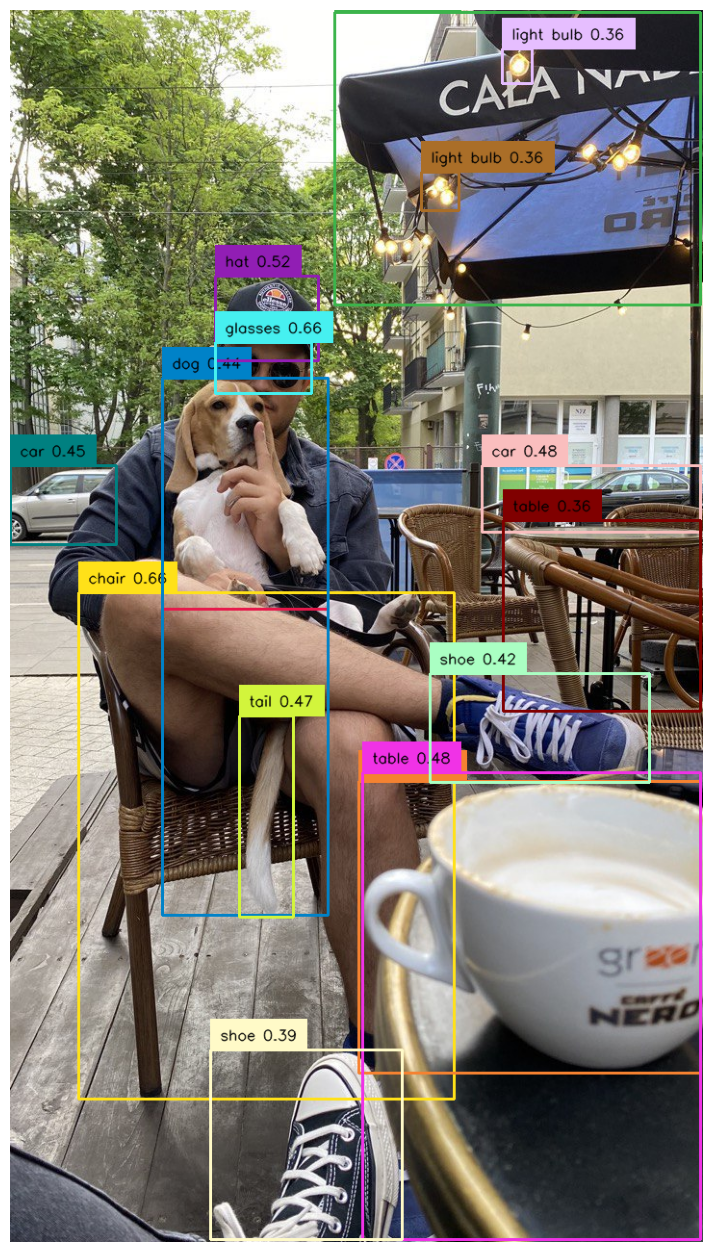

In [ ]:
TEXT_PROMPT = "chair, dog, table, shoe, light bulb, coffee, hat, glasses, car, tail, umbrella"

result_img = inference(img, TEXT_PROMPT)

plt.figure(figsize=(16, 16))
plt.imshow(result_img[:, :, ::-1])
plt.axis("off")
plt.show()

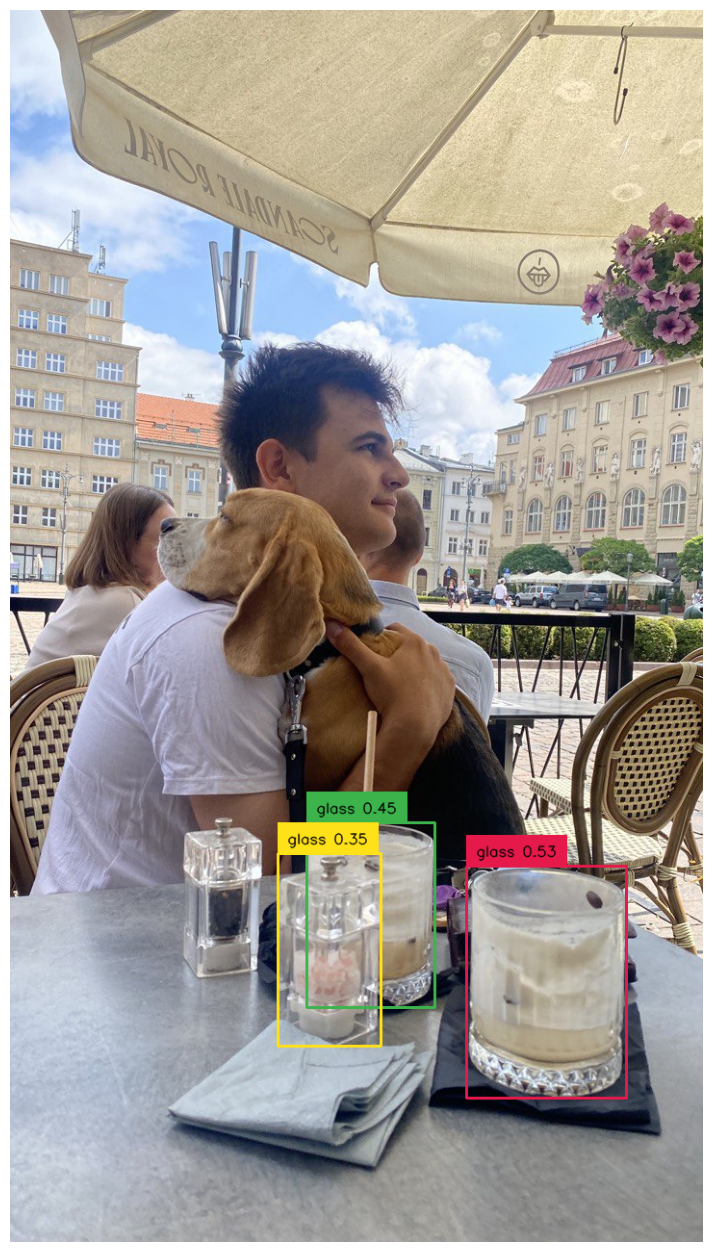

In [ ]:
IMAGE_PATH = IMAGE_PATH = "/content/dog-2.jpeg"

img = cv2.imread(IMAGE_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result_img = inference(img, "glass")

plt.figure(figsize=(16, 16))
plt.imshow(result_img[:, :, ::-1])
plt.axis("off")
plt.show()



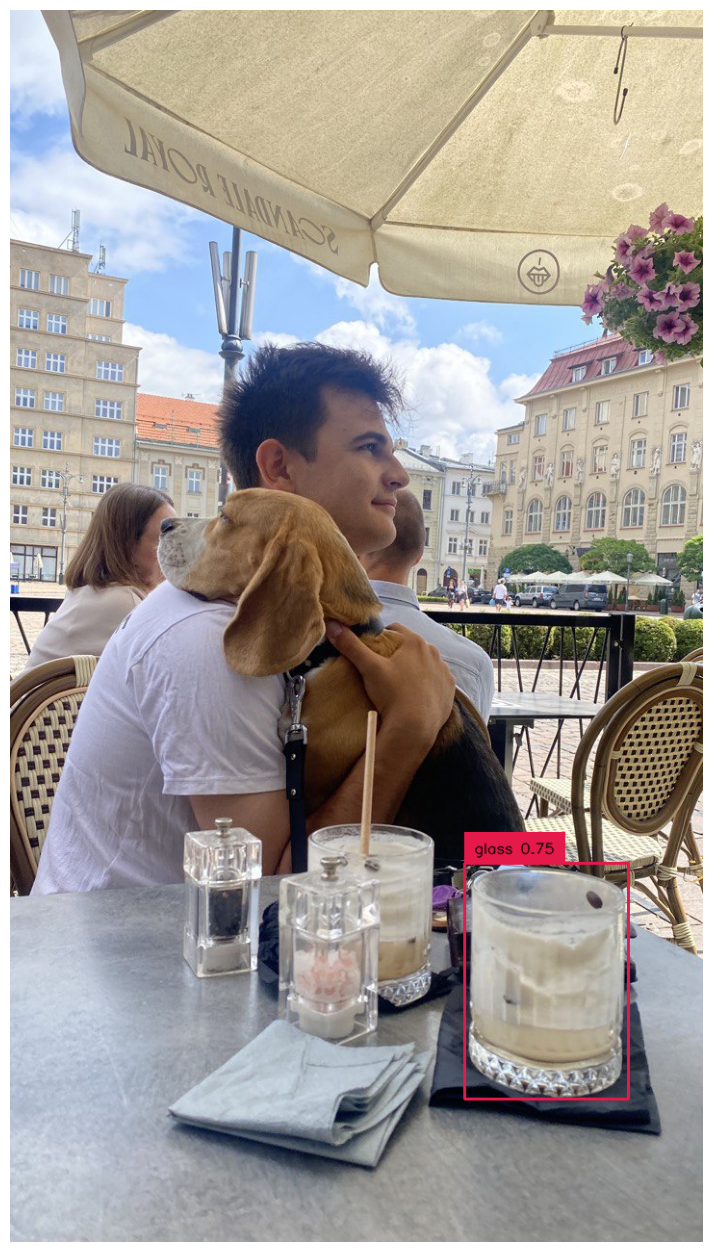

In [ ]:
TEXT_PROMPT = "glass most to the right"

result_img = inference(img, TEXT_PROMPT)

plt.figure(figsize=(16, 16))
plt.imshow(result_img[:, :, ::-1])
plt.axis("off")
plt.show()

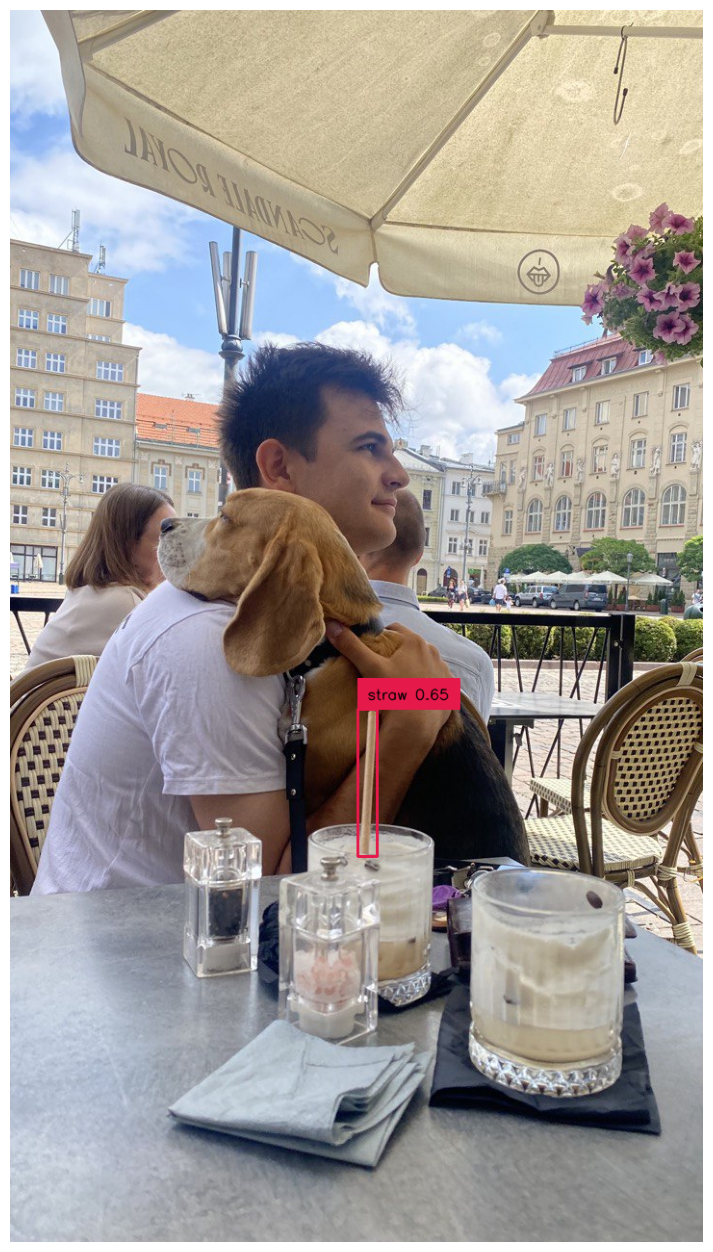

In [ ]:
TEXT_PROMPT = "straw"

result_img = inference(img, TEXT_PROMPT)

plt.figure(figsize=(16, 16))
plt.imshow(result_img[:, :, ::-1])
plt.axis("off")
plt.show()

## 이제 칼 찾아봅시다

In [ ]:
import locale
print(locale.getpreferredencoding())

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
print(locale.getpreferredencoding())

ANSI_X3.4-1968
UTF-8


## 칼 예시 사진 다운

In [ ]:
!wget -q https://dsmmagazine.com/wp-content/uploads/2014/01/favfinds_teresa.jpg -O test1.jpg
!wget -q https://img.freepik.com/premium-photo/close-up-man-holding-knife-dark_527653-12.jpg -O test2.jpg

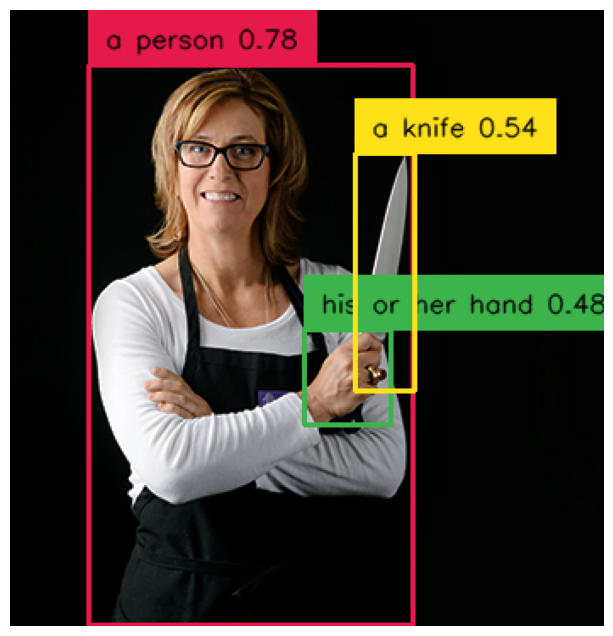

In [ ]:
TEXT_PROMPT = "A person with a knife in his or her hand"

img = cv2.imread("/content/GroundingDINO/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result_img = inference(img, TEXT_PROMPT)

plt.figure(figsize=(8, 8))
plt.imshow(result_img[:, :, ::-1])
plt.axis("off")
plt.show()

## ㅋㅋ 이게 되네

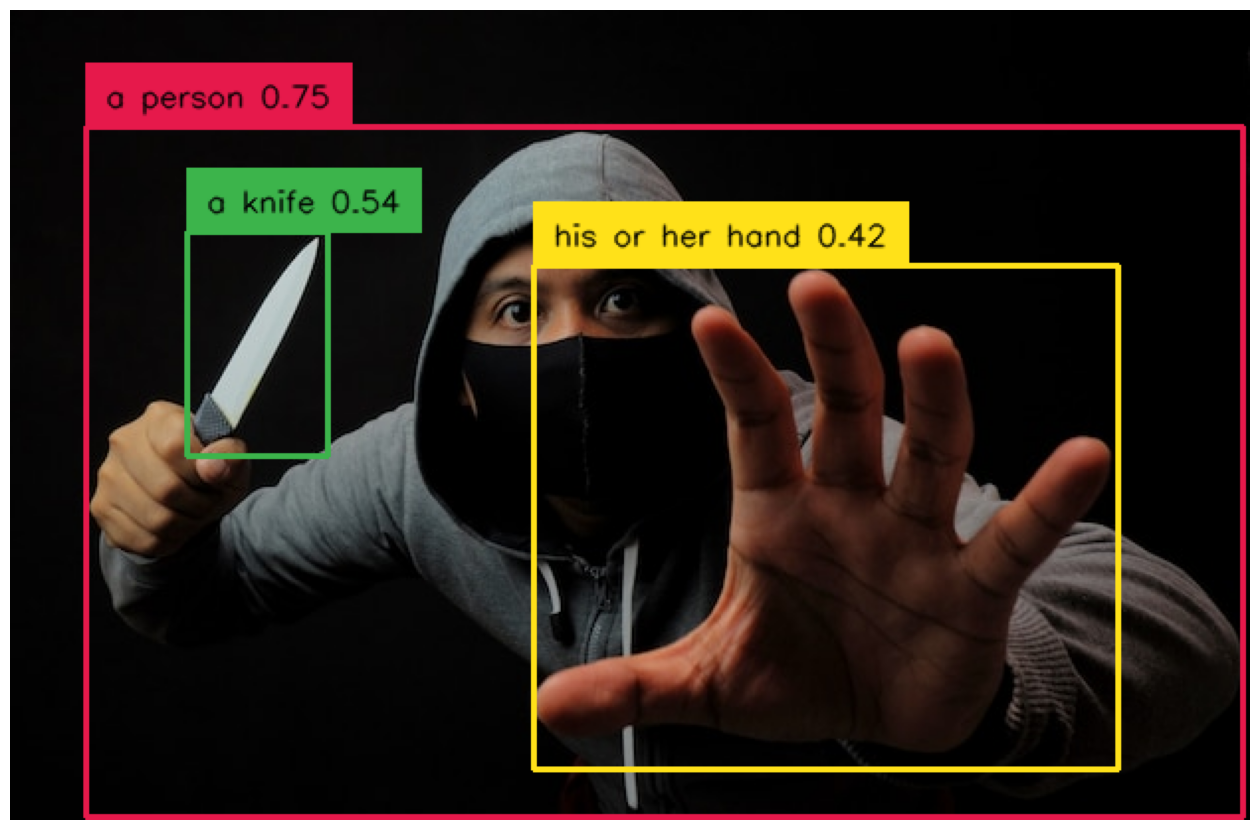

In [ ]:
TEXT_PROMPT = "A person with a knife in his or her hand"

img = cv2.imread("/content/GroundingDINO/test2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result_img = inference(img, TEXT_PROMPT)

plt.figure(figsize=(16, 16))
plt.imshow(result_img[:, :, ::-1])
plt.axis("off")
plt.show()

## 아니 영상도 된다고?

In [ ]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/knife01.mp4

In [ ]:
from google.colab import files

TEXT_PROMPT = "A person with a knife in his or her hand"

cap = cv2.VideoCapture("/content/GroundingDINO/knife01.mp4")

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('/content/output.mp4', fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    result_img = inference(img, TEXT_PROMPT)

    out.write(result_img)

out.release()

files.download('/content/output.mp4')

#이거 다운한게 맨처임거임요

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>